# Diagrams

This notebook generates all the diagrams for the paper.

In [1]:
from os.path import exists
from copy import deepcopy
import numpy
from geopandas import GeoDataFrame, GeoSeries, read_file

from sensor_placement import *
from sensor_placement.data import *
from sensor_placement.matplotlib import *

import shapely
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint, shape
from shapely.ops import cascaded_union, nearest_points, voronoi_diagram
from shapely.affinity import translate

import logging
logging.basicConfig(level=logging.INFO)

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm, TwoSlopeNorm, ListedColormap, to_rgba
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle
from matplotlib.collections import PolyCollection

## General approach

In [2]:
boundary = Polygon([Point(0.0, 0.0),
                    Point(0.0, 1.0),
                    Point(1.0, 1.0),
                    Point(1.0, 0.0)])

In [3]:
points = [Point(0.25, 0.25), Point(0.75, 0.4), Point(0.4, 0.85)]
df_samples = GeoDataFrame(points, columns=['geometry'])

In [4]:
pointsPer = 100

dx = 1 / (pointsPer + 1)
xs = [ (x + 1) * dx for x in range(pointsPer)]
ys = [ (pointsPer - y) * dx for y in range(pointsPer)]

In [5]:
bxs, bys = boundary.exterior.coords.xy

/home/sd80/programming/sensor-placement/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


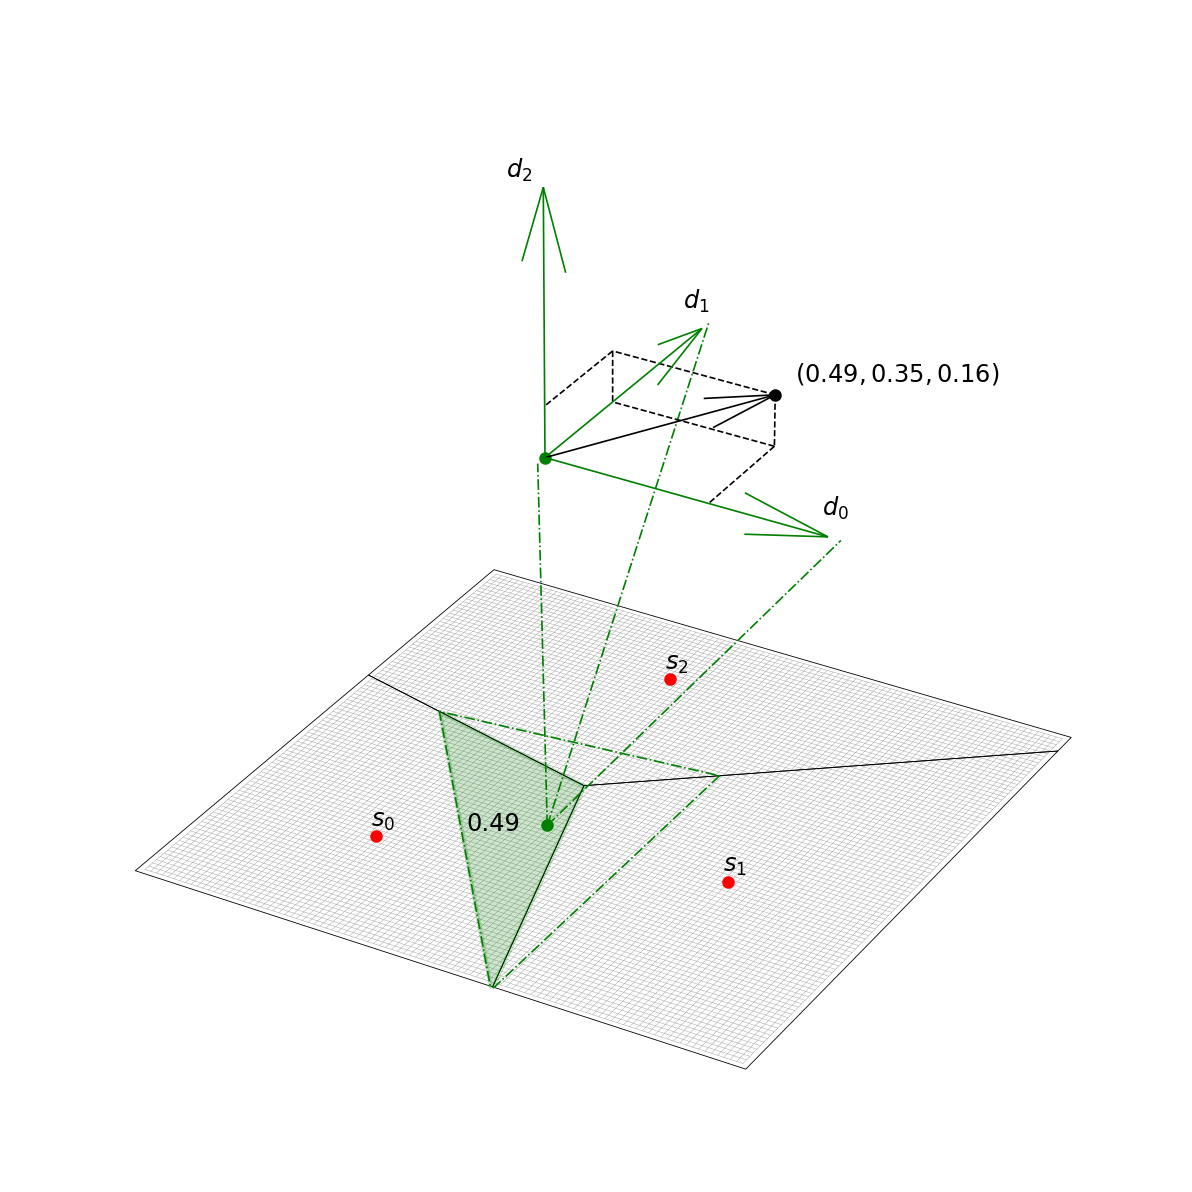

In [6]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d', xticks=[], yticks=[], zticks=[])
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_zlim([0.0, 0.8])
ax.set_frame_on(False)
ax.axis('off')
db = 0.02

# draw interpolation grid lines
for y in ys:
    ax.plot(xs, [y] * len(xs), color='0.6', linewidth=0.1)
for x in ys:
    ax.plot([x] * len(xs), ys, color='0.6', linewidth=0.1)
    
# draw sample points
for i in df_samples.geometry.index:
    pt = df_samples.geometry.loc[i]
    x, y = pt.coords.xy
    ax.plot(x[0], y[0], marker='o', color='r', markersize=2)
    ax.text(x[0] - db, y[0] + db, 0.0, f'$s_{i}$', fontsize='xx-small')

# Voronoi cells
real_points = list(df_samples.geometry)
raw_voronoi_cells = voronoi_diagram(MultiPoint(real_points), boundary)

# put cells into sample point order
voronoi_cells = []
for i in df_samples.index:
    pt = df_samples.geometry.loc[i]
    c = [c for c in raw_voronoi_cells if c.contains(pt)][0]
    voronoi_cells.append(c.intersection(boundary))
    
# draw cells
for c in voronoi_cells:
    x, y = c.exterior.xy
    ax.plot(x, y, color='k', linewidth=0.2)

# interpolation point
ix, iy = 0.45, 0.40

# synthetic cell
synthetic_points = real_points + [Point(ix, iy)]
synthetic_voronoi_cells =  voronoi_diagram(MultiPoint(synthetic_points), boundary)
synthetic_c = [synthetic_voronoi_cells.geoms[i] for i in range(len(synthetic_voronoi_cells.geoms)) if Point(ix, iy).within(synthetic_voronoi_cells.geoms[i])][0]

# draw synthetic cell
x, y = synthetic_c.intersection(boundary).exterior.xy
ax.plot(x, y, color='g', linestyle='-.', linewidth=0.4)

# weights
w = []
synthetic_area = synthetic_c.area
for c in voronoi_cells:
    area = c.intersection(synthetic_c).area
    w.append(area / synthetic_area)

# chosen overlap to highlight
ci = 0
chosen = voronoi_cells[ci].intersection(synthetic_c)
vertices = [list(chosen.exterior.coords)]
poly = PolyCollection(vertices, color='g')
poly.set_alpha(0.2)
ax.add_collection3d(poly)
    
# annotate overlap with its weight
x, y = chosen.centroid.coords.xy
ax.text(x[0] - 2 * db, y[0] - 2 * db, 0.0, '{dw:.2f}'.format(dw=w[ci]), fontsize='xx-small')

# draw and label vector space axes
iz = 0.65
dx = 0.45
ax.plot(ix, iy, iz, marker='o', color='g', markersize=2)
ax.quiver(ix, iy, iz, dx, 0.0, 0.0, color='g', linewidth=0.4)
ax.quiver(ix, iy, iz, 0.0, dx, 0.0, color='g', linewidth=0.4)
ax.quiver(ix, iy, iz, 0.0, 0.0, dx, color='g', linewidth=0.4)
ax.text(ix + dx - db, iy + db, iz + db, '$d_0$', fontsize='xx-small')
ax.text(ix - db, iy + dx - db, iz + 2 * db, '$d_1$', fontsize='xx-small')
ax.text(ix - 3 * db, iy, iz + dx, '$d_2$', fontsize='xx-small')

# explode interpolation point to axes
ax.plot(ix, iy, 0.0, marker='o', color='g', markersize=2)
ax.plot([ix, ix], [iy, iy - db], [0.0, iz], color='g', linestyle='-.', linewidth=0.4)
ax.plot([ix, ix + dx + db], [iy, iy], [0.0, iz], color='g', linestyle='-.', linewidth=0.4)
ax.plot([ix, ix], [iy, iy + dx + db], [0.0, iz], color='g', linestyle='-.', linewidth=0.4)

# draw weight covector
dw = 1.2 * dx
wx, wy, wz = ix + w[0] * dw, iy + w[1] * dw, iz + w[2] * dw
ax.quiver(ix, iy, iz, w[0] * dw, w[1] * dw, w[2] * dw, color='k', linewidth=0.4)
ax.plot(wx, wy, wz, marker='o', color='k', markersize=2)
ax.text(wx + db, wy + db, wz + db,
       '$({wx:.2f}, {wy:.2f}, {wz:.2f})$'.format(wx=w[0], wy = w[1], wz=w[2]), fontsize='xx-small')

# draw lines from covector to axes
ax.plot([wx, ix], [wy, wy], [wz, wz], color='k', linestyle='--', linewidth=0.4)
ax.plot([ix, ix], [wy, iy], [wz, wz], color='k', linestyle='--', linewidth=0.4)
ax.plot([ix, ix], [wy, wy], [wz, iz], color='k', linestyle='--', linewidth=0.4)
ax.plot([wx, wx], [wy, wy], [wz, iz], color='k', linestyle='--', linewidth=0.4)
ax.plot([wx, wx], [wy, iy], [iz, iz], color='k', linestyle='--', linewidth=0.4)
ax.plot([wx, ix], [wy, wy], [iz, iz], color='k', linestyle='--', linewidth=0.4)
    
plt.savefig('diagrams/interpolation-vector-space.png')
_ = plt.show()

## Projection into 2d

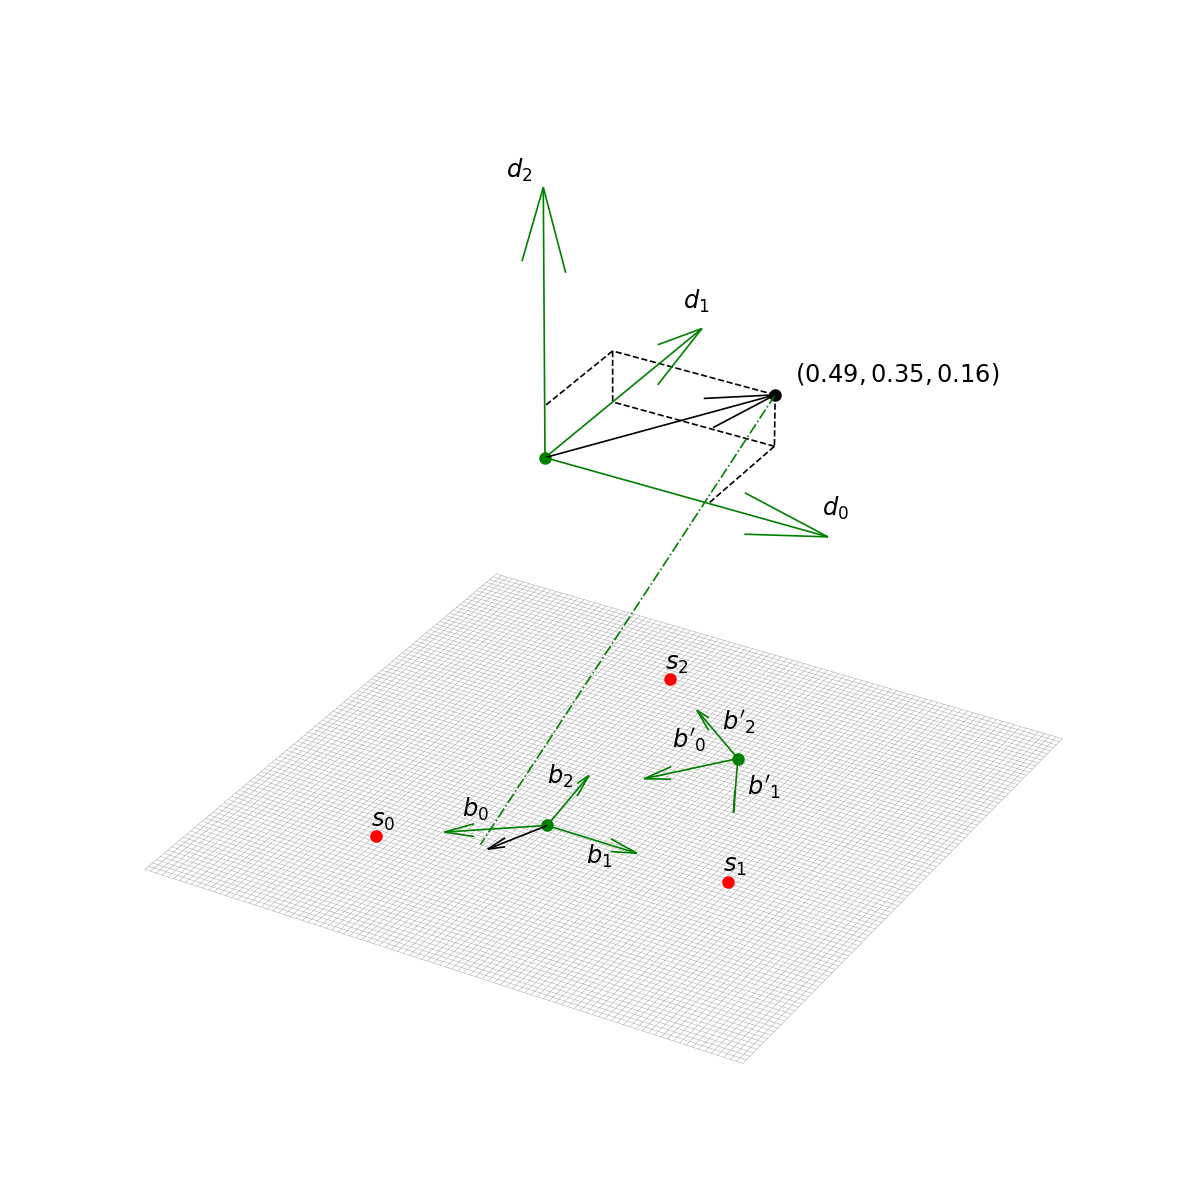

In [7]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d', xticks=[], yticks=[], zticks=[])
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_zlim([0.0, 0.8])
ax.set_frame_on(False)
ax.axis('off')

# draw interpolation grid lines
for y in ys:
    ax.plot(xs, [y] * len(xs), color='0.6', linewidth=0.1)
for x in ys:
    ax.plot([x] * len(xs), ys, color='0.6', linewidth=0.1)
    
# draw sample points
for i in df_samples.geometry.index:
    pt = df_samples.geometry.loc[i]
    x, y = pt.coords.xy
    ax.plot(x[0], y[0], marker='o', color='r', markersize=2)
    ax.text(x[0] - db, y[0] + db, 0.0, f'$s_{i}$', fontsize='xx-small')

# draw and label vector space axes
ax.plot(ix, iy, iz, marker='o', color='g', markersize=2)
ax.quiver(ix, iy, iz, dx, 0.0, 0.0, color='g', linewidth=0.4)
ax.quiver(ix, iy, iz, 0.0, dx, 0.0, color='g', linewidth=0.4)
ax.quiver(ix, iy, iz, 0.0, 0.0, dx, color='g', linewidth=0.4)
ax.text(ix + dx - db, iy + db, iz + db, '$d_0$', fontsize='xx-small')
ax.text(ix - db, iy + dx - db, iz + 2 * db, '$d_1$', fontsize='xx-small')
ax.text(ix - 3 * db, iy, iz + dx, '$d_2$', fontsize='xx-small')

# draw weight covector
ax.quiver(ix, iy, iz, w[0] * dw, w[1] * dw, w[2] * dw, color='k', linewidth=0.4)
ax.plot(wx, wy, wz, marker='o', color='k', markersize=2)
ax.text(wx + db, wy + db, wz + db,
       '$({wx:.2f}, {wy:.2f}, {wz:.2f})$'.format(wx=w[0], wy = w[1], wz=w[2]), fontsize='xx-small')

# draw lines from covector to axes
ax.plot([wx, ix], [wy, wy], [wz, wz], color='k', linestyle='--', linewidth=0.4)
ax.plot([ix, ix], [wy, iy], [wz, wz], color='k', linestyle='--', linewidth=0.4)
ax.plot([ix, ix], [wy, wy], [wz, iz], color='k', linestyle='--', linewidth=0.4)
ax.plot([wx, wx], [wy, wy], [wz, iz], color='k', linestyle='--', linewidth=0.4)
ax.plot([wx, wx], [wy, iy], [iz, iz], color='k', linestyle='--', linewidth=0.4)
ax.plot([wx, ix], [wy, wy], [iz, iz], color='k', linestyle='--', linewidth=0.4)

# compute basis vectors
b = []
for i in df_samples.geometry.index:
    pt = df_samples.geometry.loc[i]
    bx, by = makeVector(Point(ix, iy), pt, dx / 3)
    b.append((bx, by))
    
# draw sample point and projection basis vectors
ax.plot(ix, iy, 0.0, marker='o', color='g', markersize=2)
for (x, y) in b:
    ax.quiver(ix, iy, 0.0, x, y, 0.0, color='g', linewidth=0.4)
ax.text(ix - 6 * db, iy - 2 * db, 0.0, '$b_0$', fontsize='xx-small')
ax.text(ix + 5 * db, iy - 3 * db, 0.0, '$b_1$', fontsize='xx-small')
ax.text(ix - 3 * db, iy + 5 * db, 0.0, '$b_2$', fontsize='xx-small')

# resolve weight covector onto projection basis
rx, ry = 0, 0
for i in df_samples.geometry.index:
    pt = df_samples.geometry.loc[i]
    bx, by = makeVector(Point(ix, iy), pt, (dx / 3) * w[i] * 5)
    rx += bx
    ry += by
ax.quiver(ix, iy, 0.0, rx, ry, 0.0, color='k', linewidth=0.4)

# explode interpolation vector to projection space
ax.plot([ix + w[0] * dw, ix + rx], [iy + w[1] * dw, iy + ry - db], [iz + w[2] * dw, 0.0 + db], color='g', linestyle='-.', linewidth=0.4)

# draw an alternative sample point and projection basis vectors
ox, oy = 0.6, 0.7
ob = []
for i in df_samples.geometry.index:
    pt = df_samples.geometry.loc[i]
    bx, by = makeVector(Point(ox, oy), pt, dx / 3)
    ob.append((bx, by))
ax.plot(ox, oy, 0.0, marker='o', color='g', markersize=2)
for (x, y) in ob:
    ax.quiver(ox, oy, 0.0, x, y, 0.0, color='g', linewidth=0.4)
ax.text(ox - 5 * db, oy - db, 0.0, '$b\'_0$', fontsize='xx-small')
ax.text(ox + 3 * db, oy - 4 * db, 0.0, '$b\'_1$', fontsize='xx-small')
ax.text(ox - 3 * db, oy + 3 * db, 0.0, '$b\'_2$', fontsize='xx-small')

plt.savefig('diagrams/interpolation-projection.png')
_ = plt.show()

## Full-resolution synthetic dataset

In [8]:
samplesPer = 5

nSamples = samplesPer * samplesPer

In [9]:
dx = 1 / (samplesPer + 1)
points = []
for y in range(samplesPer):
    for x in range(samplesPer):
        points.append(Point(((x + 1) * dx, (samplesPer - y) * dx)))

df_samples = GeoDataFrame(points, columns=['geometry'])

In [10]:
samples = numpy.full((nSamples,), fill_value=5)

samples[0] = 20
samples[2] = 15
samples[3] = 12
samples[4] = 15
samples[5] = 10
samples[1] = 10
samples[10] = 8
samples[13] = 35
samples[15] = 16
samples[16] = 5
samples[20] = 22
samples[21] = 25
samples[24] = 1

In [11]:
if exists('datasets/tensor_fullresolution.nc'):
    tensor_fullresolution = NNNI.load('datasets/tensor_fullresolution.nc')
else:
    raise Exception('Can\'t load tensor')

INFO:sensor_placement:Tensor will use up to 1 core
INFO:sensor_placement:Created Voronoi diagram in 0.00s
INFO:sensor_placement:Loaded tensor from datasets/tensor_fullresolution.nc in 0.00s


INFO:sensor_placement:Applied tensor in 0.00s


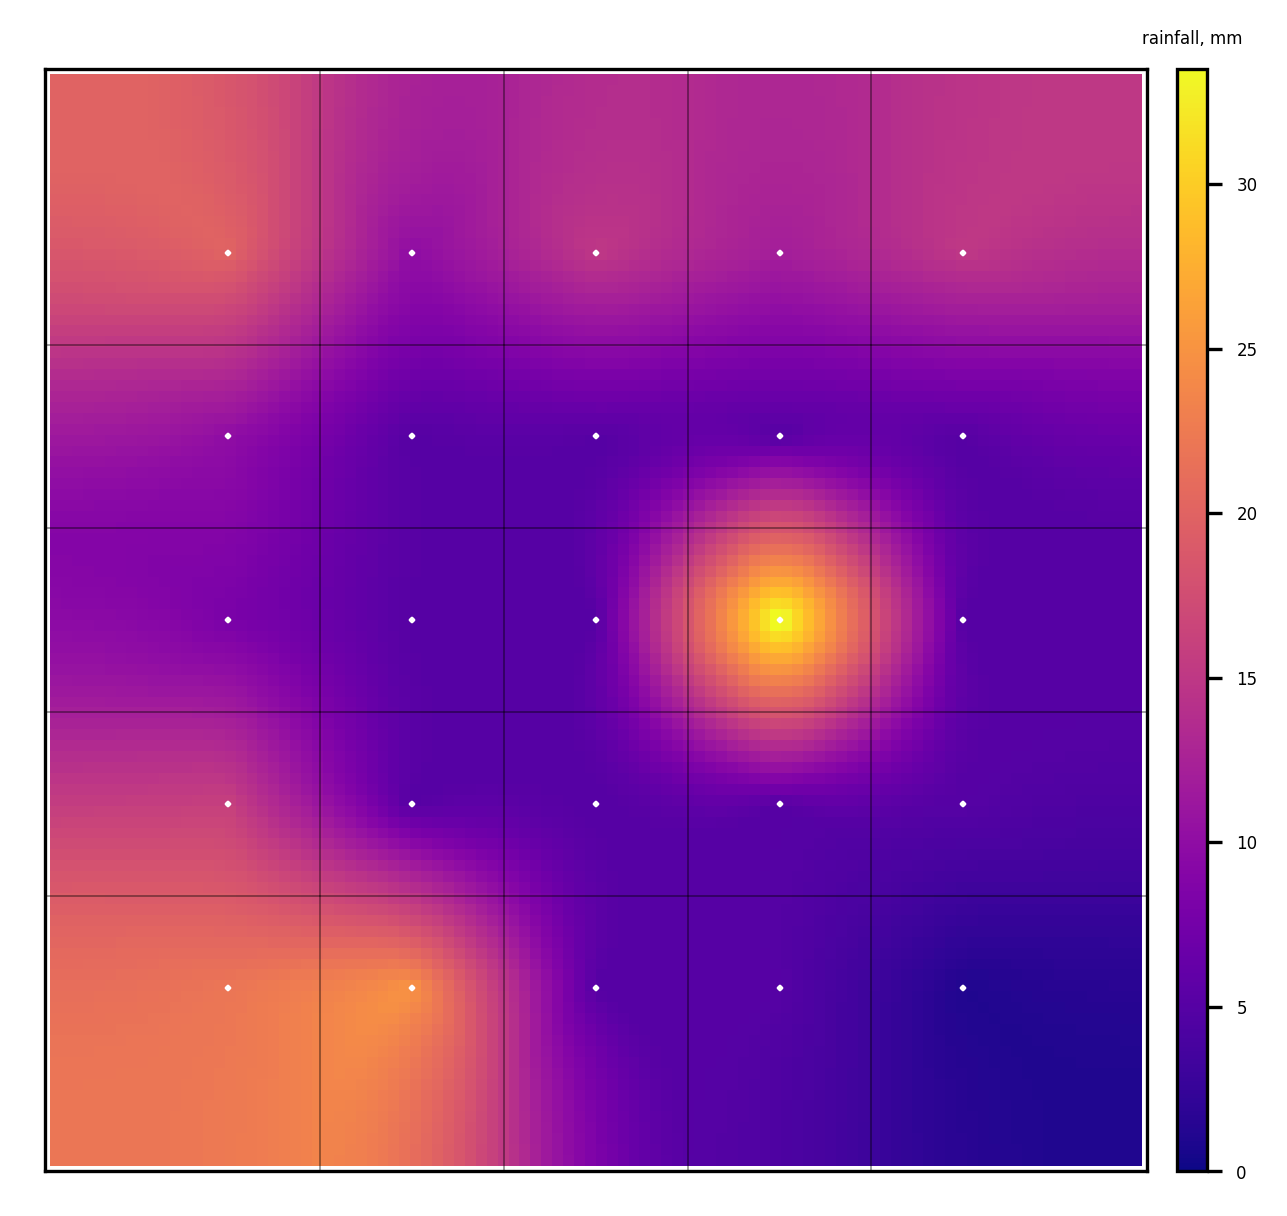

In [21]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
_, _, norm = drawInterpolation(tensor_fullresolution, samples, ax=ax, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
drawVoronoiCells(tensor_fullresolution, ax=ax)
drawSampleLabels(tensor_fullresolution, ax=ax, color='w', include_sample_labels=False, include_sample_indices=False)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

plt.savefig('diagrams/fullresolution.png')
_ = plt.show()

INFO:sensor_placement:Applied tensor in 0.00s


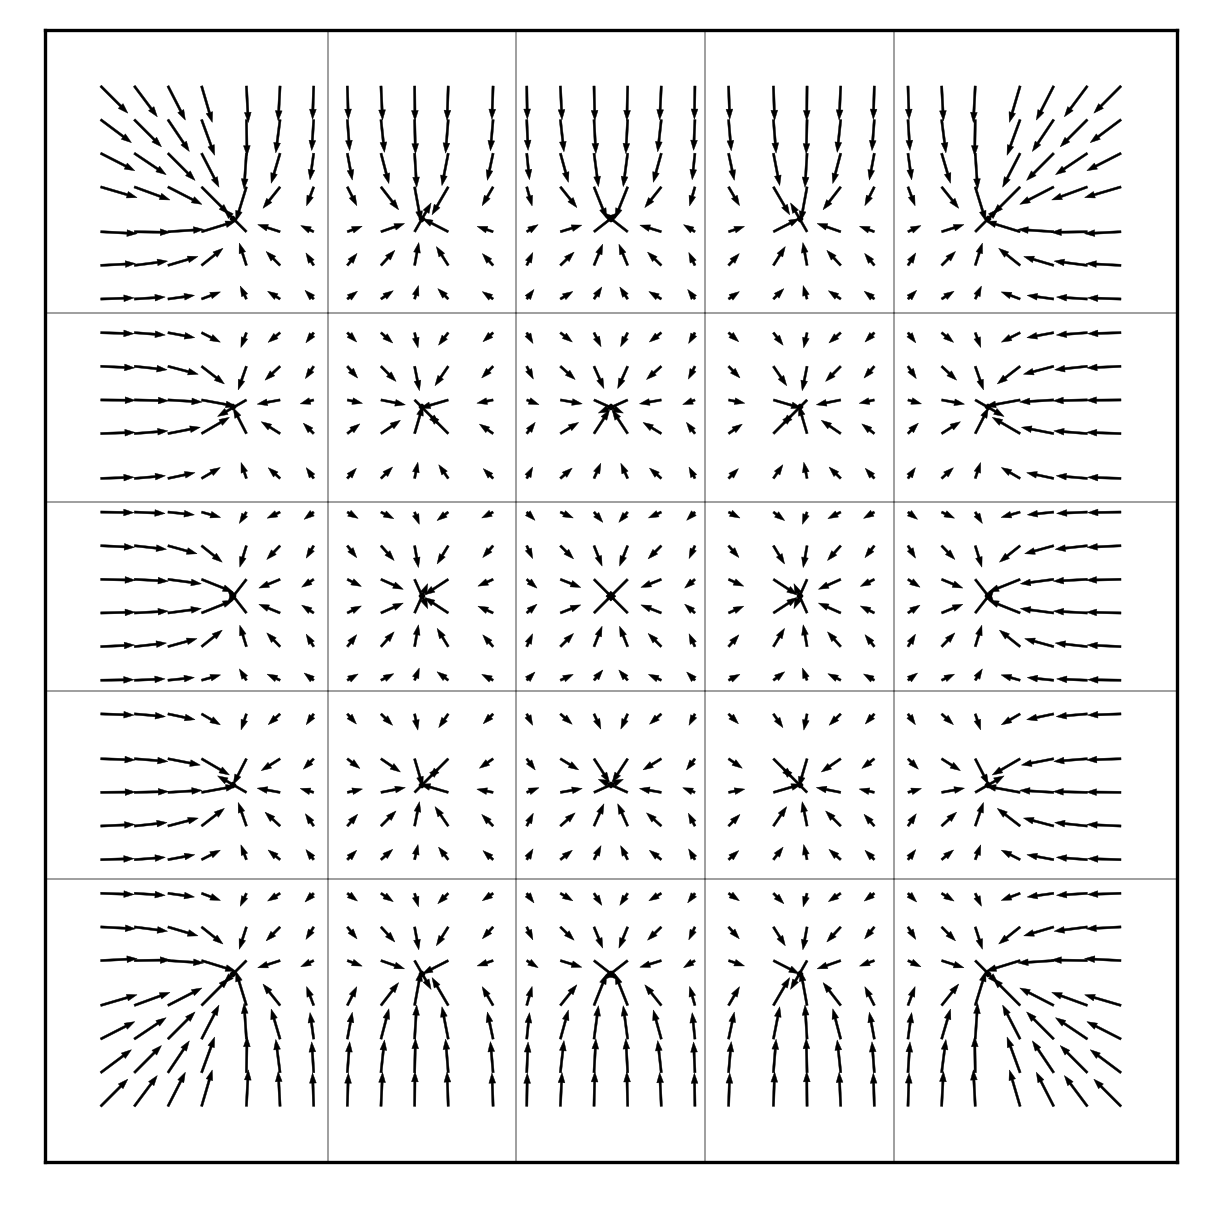

In [22]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

drawInterpolation(tensor_fullresolution, samples, ax=ax, include_interpolation=False)
for x in numpy.linspace(0.05, 0.95, 30):
    for y in numpy.linspace(0.05, 0.95, 30):
        drawResolvedVector(tensor_fullresolution, nearestPointTo(Point(x, y), tensor_fullresolution),
                           ax=ax, color='k', radius=0.025)
drawVoronoiCells(tensor_fullresolution, ax=ax)
drawSampleLabels(tensor_fullresolution, ax=ax, color='k', include_sample_labels=False, include_sample_indices=False)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

plt.savefig('diagrams/fullresolution-vectors.png')
_ = plt.show()

## Degraded sample

In [17]:
if exists('datasets/tensor_60.nc'):
    tensor_60 = NNNI.load('datasets/tensor_60.nc')
    retain_60 = list(tensor_60._samples.index)
    samples_60 = samples[retain_60]    
else:
    raise Exception('Can\'t load tensor')

INFO:sensor_placement:Tensor will use up to 1 core
INFO:sensor_placement:Created Voronoi diagram in 0.00s
INFO:sensor_placement:Loaded tensor from datasets/tensor_60.nc in 0.00s


INFO:sensor_placement:Applied tensor in 0.00s


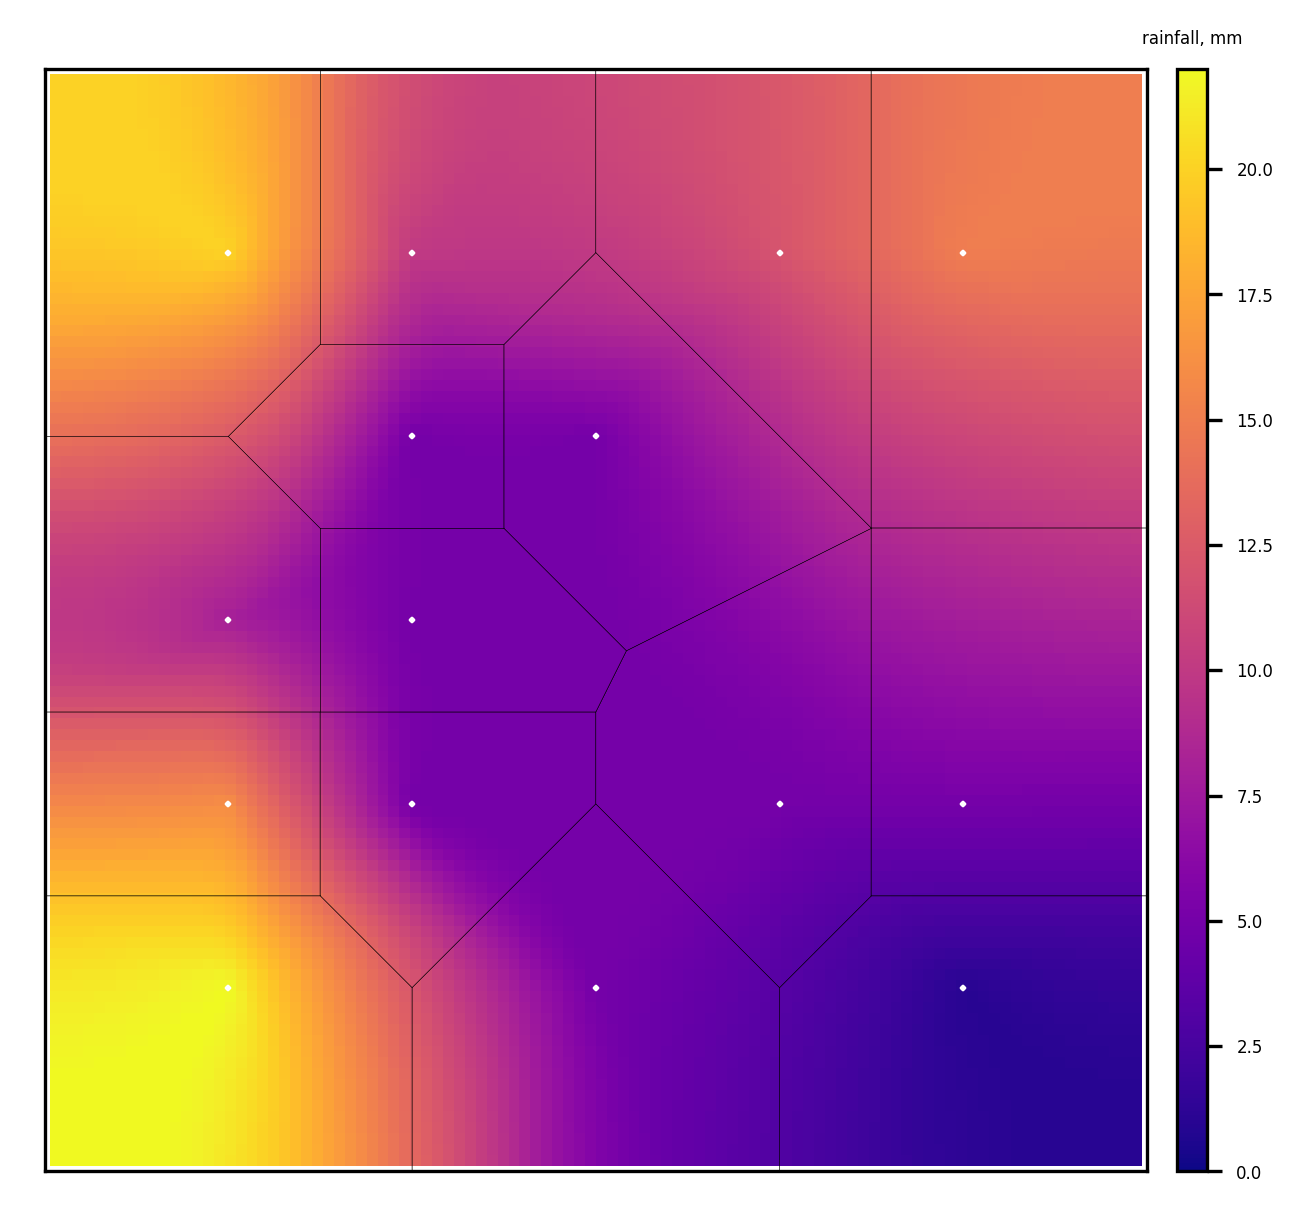

In [23]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
_, _, norm = drawInterpolation(tensor_60, samples_60, ax=ax, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
drawVoronoiCells(tensor_60, ax=ax)
drawSampleLabels(tensor_60, ax=ax, color='w', include_sample_labels=False, include_sample_indices=False)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

plt.savefig('diagrams/degraded60.png')
_ = plt.show()

INFO:sensor_placement:Applied tensor in 0.00s


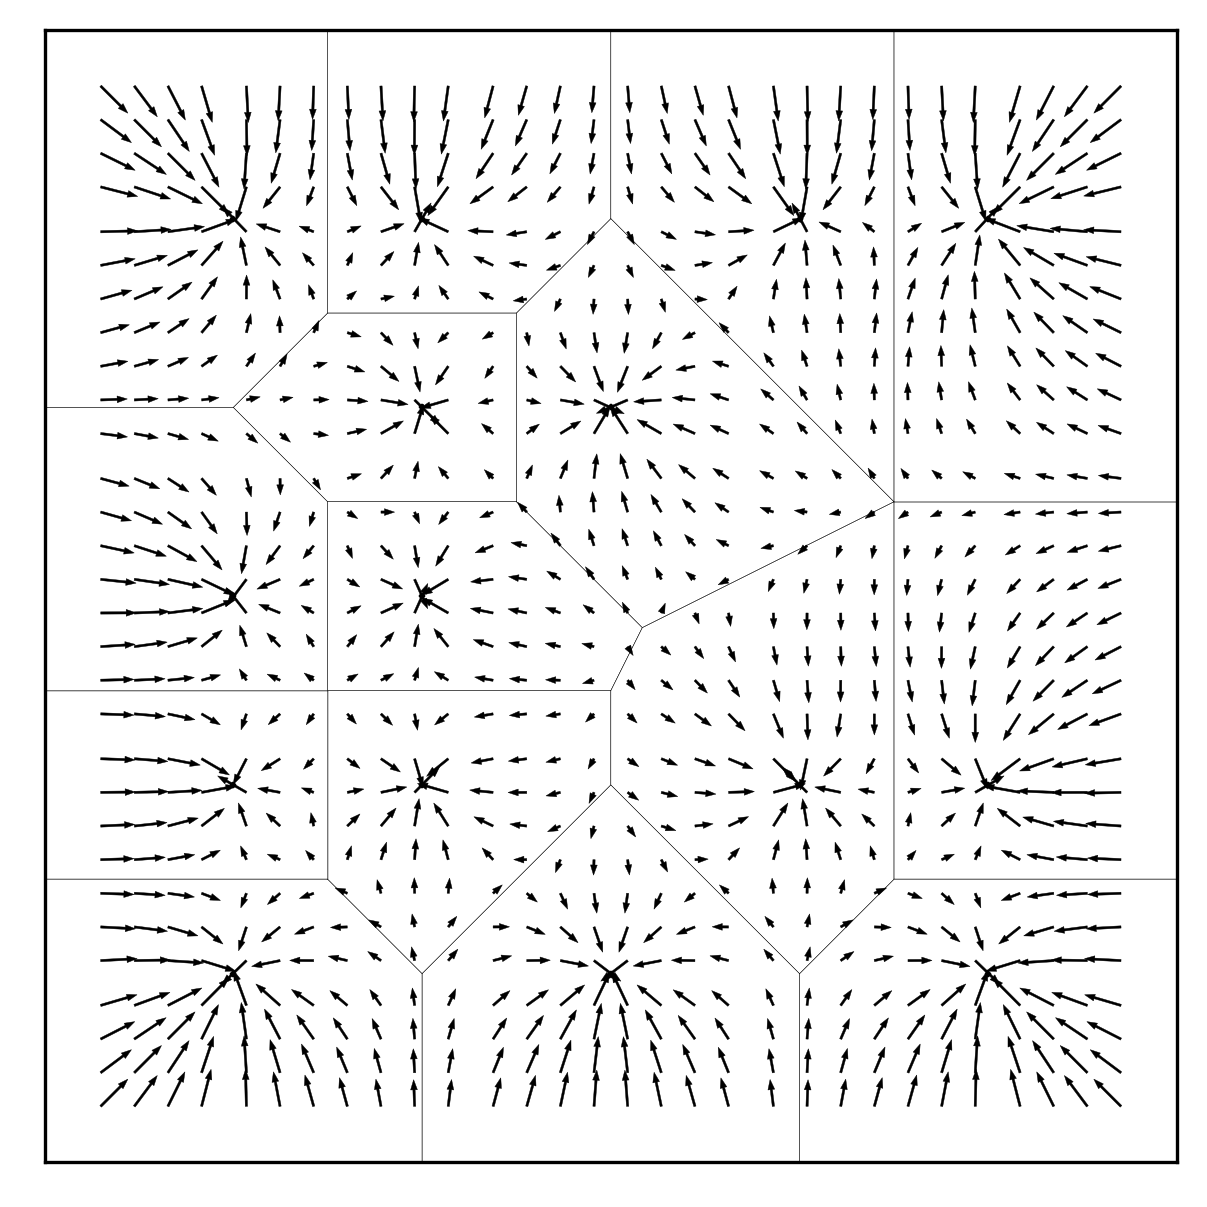

In [24]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

drawInterpolation(tensor_60, samples_60, ax=ax, include_interpolation=False)
for x in numpy.linspace(0.05, 0.95, 30):
    for y in numpy.linspace(0.05, 0.95, 30):
        drawResolvedVector(tensor_60, nearestPointTo(Point(x, y), tensor_60),
                           ax=ax, color='k', radius=0.025)
drawVoronoiCells(tensor_60, ax=ax)
drawSampleLabels(tensor_60, ax=ax, color='k', include_sample_labels=False, include_sample_indices=False)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

plt.savefig('diagrams/degraded60-vectors.png')
_ = plt.show()

## Assessing the effects of degradation

In [26]:
g_diff = tensor_fullresolution.apply(samples) - tensor_60.apply(samples_60)

INFO:sensor_placement:Applied tensor in 0.00s
INFO:sensor_placement:Applied tensor in 0.00s


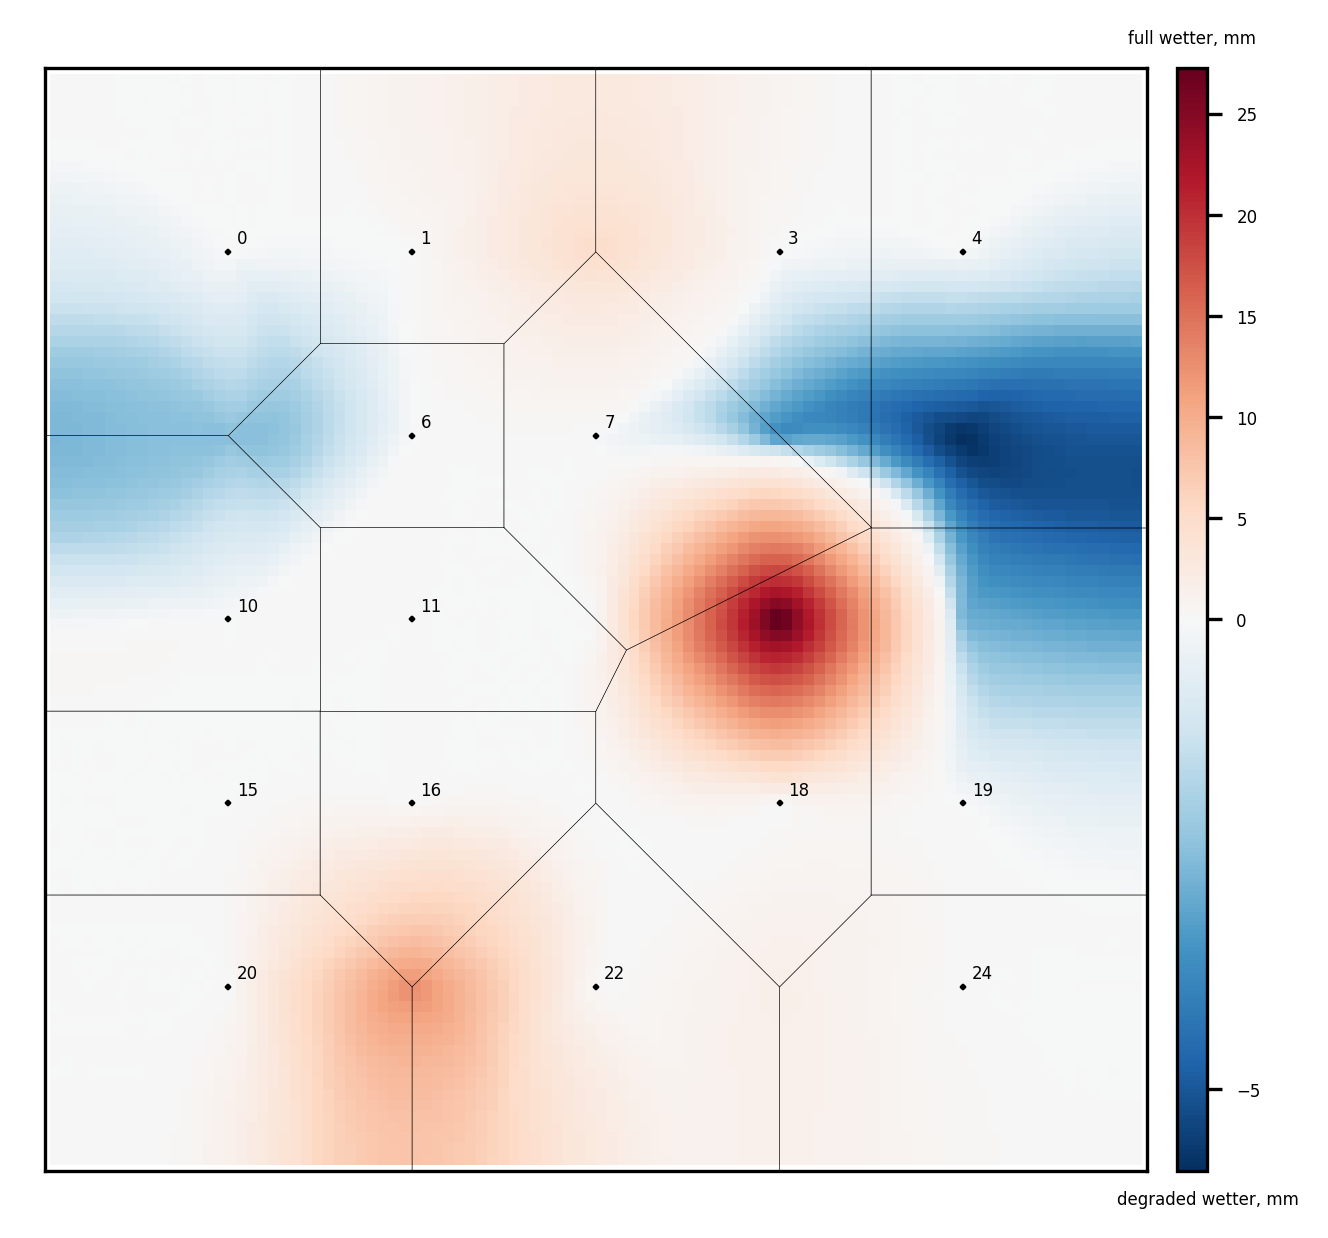

In [27]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
norm_diff = TwoSlopeNorm(vcenter=0, vmin=g_diff.min(), vmax=g_diff.max())
_, cax, _ = drawGrid(g_diff, xs, ys, ax=ax, norm=norm_diff, cmap=cm.get_cmap('RdBu_r'), cmap_title='full wetter, mm')
drawVoronoiCells(tensor_60, ax=ax)
drawSampleLabels(tensor_60, ax=ax, include_sample_indices=False)
cax.annotate('degraded wetter, mm', xy=(0.5, 0.0), xycoords='axes points', xytext=(-15, -8), textcoords='offset points', fontsize=4)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

plt.savefig('diagrams/fullresolution-degraded60.png')
_ = plt.show()

In [31]:
def contribution(tensor, s):
    si = tensor._voronoi.index.get_loc(s)
    tensor_si = tensor._tensor[:, :, si]
    return numpy.sum(tensor_si)

In [32]:
contributions = []
for s, _ in tensor_60._samples.iterrows():
    contributions.append(contribution(tensor_60, s))
tensor_60._samples['contribution'] = contributions

In [33]:
contribution_60_max = tensor_60._samples[tensor_60._samples['contribution'] == tensor_60._samples['contribution'].max()]
contribution_60_max_sample = contribution_60_max.index[0]
contribution_60_max_point = tensor_60._samples.loc[contribution_60_max_sample].geometry

In [34]:
tensor_59 = deepcopy(tensor_60)
tensor_59.removeSample(contribution_60_max_sample)

In [35]:
contribution_60_max_index = tensor_60._samples.index.get_loc(contribution_60_max_sample)
samples_59 = numpy.delete(samples_60, contribution_60_max_index)
pt = contribution_60_max_point.coords[0]

INFO:sensor_placement:Applied tensor in 0.00s


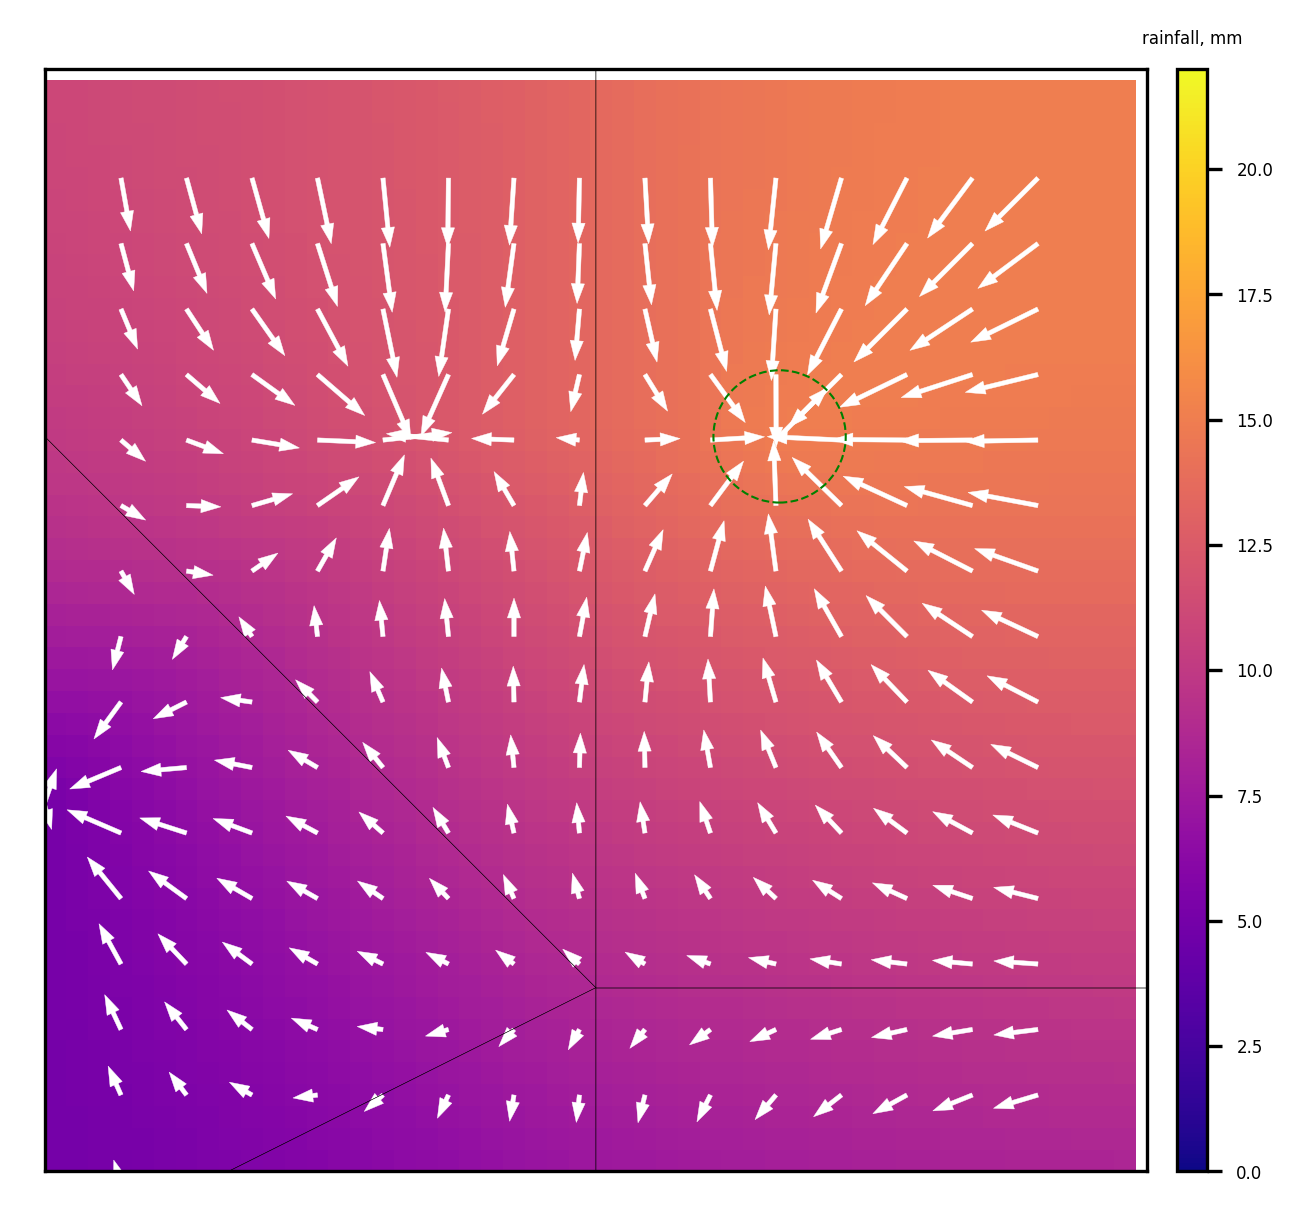

In [44]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
drawInterpolation(tensor_60, samples_60, ax=ax, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
for x in numpy.linspace(0.5, 0.95, 16):
    for y in numpy.linspace(0.5, 0.95, 16):
        drawResolvedVector(tensor_60, nearestPointTo(Point(x, y), tensor_60),
                           ax=ax, color='w', radius=0.025)
drawVoronoiCells(tensor_60, ax=ax)
c = Circle(pt, radius=0.03,
           linestyle='--', linewidth=0.5, fill=False, color='g')
ax.add_artist(c)
ax.set_xlim([0.5, 1.0])
ax.set_ylim([0.5, 1.0])

plt.savefig('diagrams/degraded60-detail.png')
_ = plt.show()

INFO:sensor_placement:Applied tensor in 0.00s


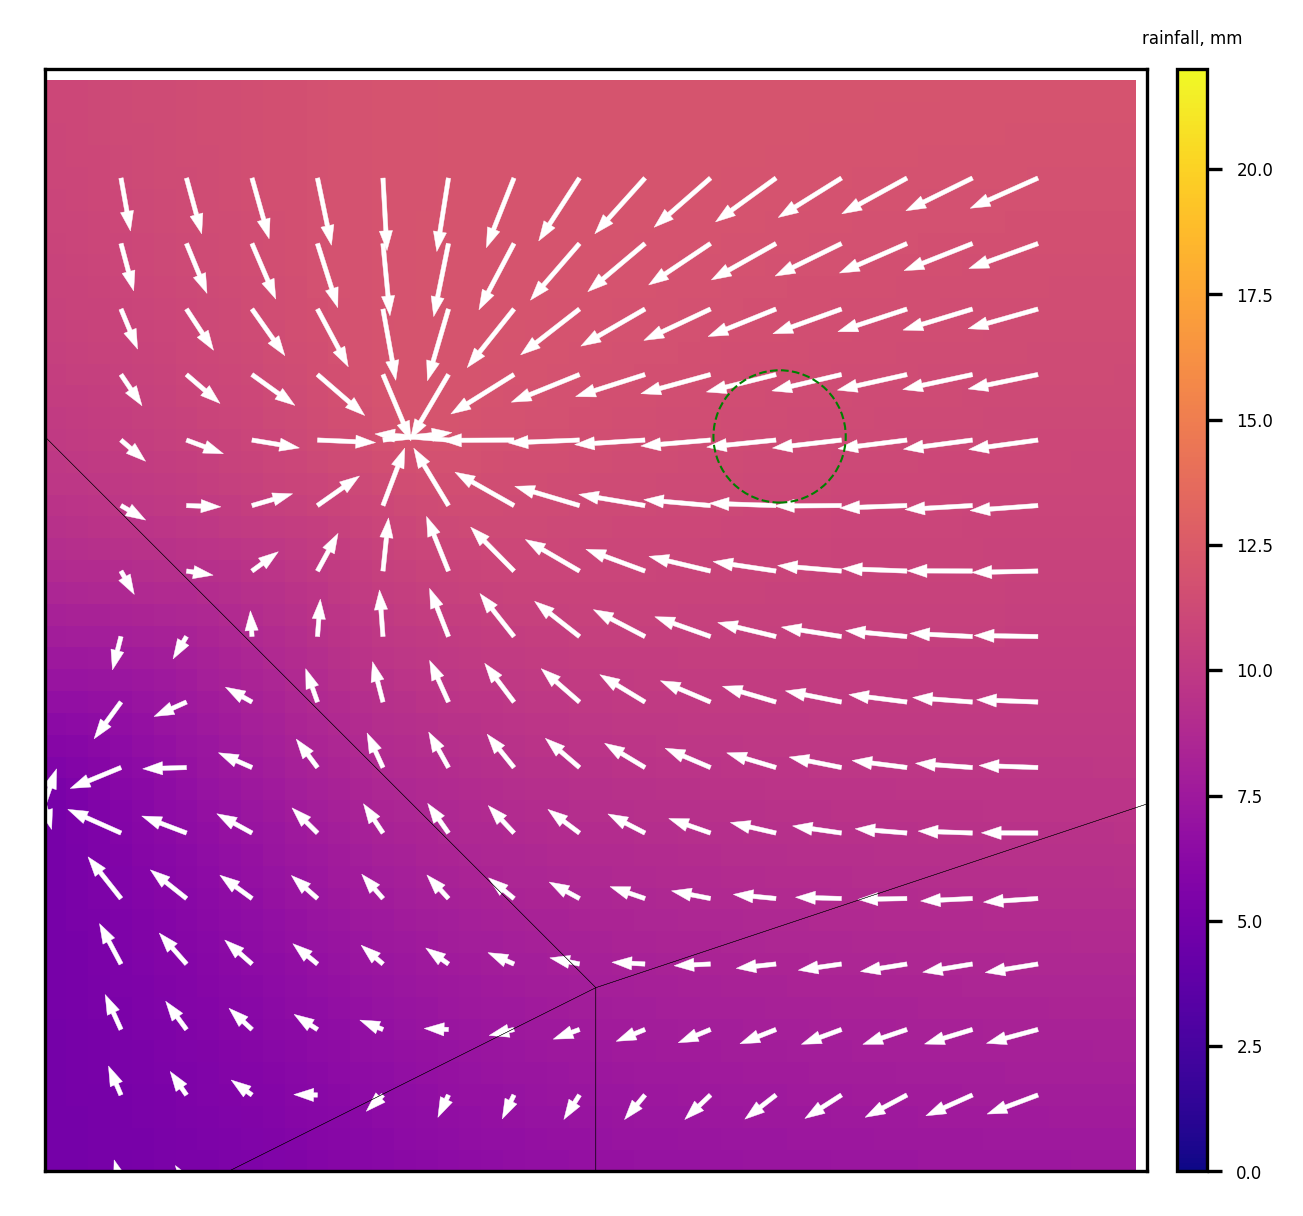

In [38]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
drawInterpolation(tensor_59, samples_59, ax=ax, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
for x in numpy.linspace(0.5, 0.95, 16):
    for y in numpy.linspace(0.5, 0.95, 16):
        drawResolvedVector(tensor_59, nearestPointTo(Point(x, y), tensor_59),
                           ax=ax, color='w', radius=0.025)
drawVoronoiCells(tensor_59, ax=ax)
c = Circle(pt, radius=0.03,
           linestyle='--', linewidth=0.5, fill=False, color='g')
ax.add_artist(c)
ax.set_xlim([0.5, 1.0])
ax.set_ylim([0.5, 1.0])

plt.savefig('diagrams/degraded59-detail.png')
_ = plt.show()

In [42]:
def cosineDistance(v, w):
    d = numpy.dot(v, w)
    mag_v = numpy.sqrt(numpy.dot(v, v))
    mag_w = numpy.sqrt(numpy.dot(w, w))
    return 1 - d / (mag_v * mag_w)

In [40]:
def computeTurn(tensor, s):
    '''Compute the turning field caused by the removal of the given sample.'''

    # extract grid
    xs, ys = tensor._xs, tensor._ys
    
    # record the index of the sample to be removed
    si = tensor._samples.index.get_loc(s)
    
    # construct the tensor induced by removing s
    reduced = deepcopy(tensor)
    reduced.removeSample(s)
    
    # construct the turning grid
    ts = numpy.zeros((len(xs), len(ys)))
    for i in range(len(xs)):
        for j in range(len(ys)):
            v = tensor._tensor[i, j, :]
            w = reduced._tensor[i, j, :]
            
            # extend the reduced vector with a zero at the correct index
            w1 = numpy.append(w, numpy.zeros((1)))
            w1[si + 1:] = w1[si:-1]
            w1[si] = 0.0
            
            # compute the angle
            ts[i, j] = cosineDistance(v, w1)
            
    # return the turning field and the reduced tensor
    return ts, reduced

def drawTurn(ts,
             ax=None, cmap=None, cmap_title=None, norm=None, fontsize=4,
             include_colorbar=True):
    '''Draw the turning of the vector field.'''

    # fill in defaults
    if ax is None:
        ax = plt.gca()
    if cmap is None:
        cmap = cm.get_cmap('viridis')
    if cmap_title is None:
        cmap_title = '$1 - cos \, \\theta$'
    
    # construct a mesh
    xx, yy = numpy.meshgrid(xs, ys)

    # create the colours on the mesh
    if norm is None:
        norm = Normalize(vmin=ts.min(), vmax=ts.max())
    ax.pcolormesh(xx, yy, ts.T, cmap=cmap, norm=norm)
    ax.set_aspect(1.0)

    # add colorbar
    if include_colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", 0.1, pad=0.1, sharex=ax)
        matplotlib.colorbar.Colorbar(ax=cax, cmap=cmap, norm=norm)
        cax.tick_params(labelsize=fontsize)
        if cmap_title is not None:
            cax.set_title(cmap_title, fontsize=fontsize)
    else:
        cax = None

    # return the main and colorbar axes, and the norm used,
    return ax, cax, norm

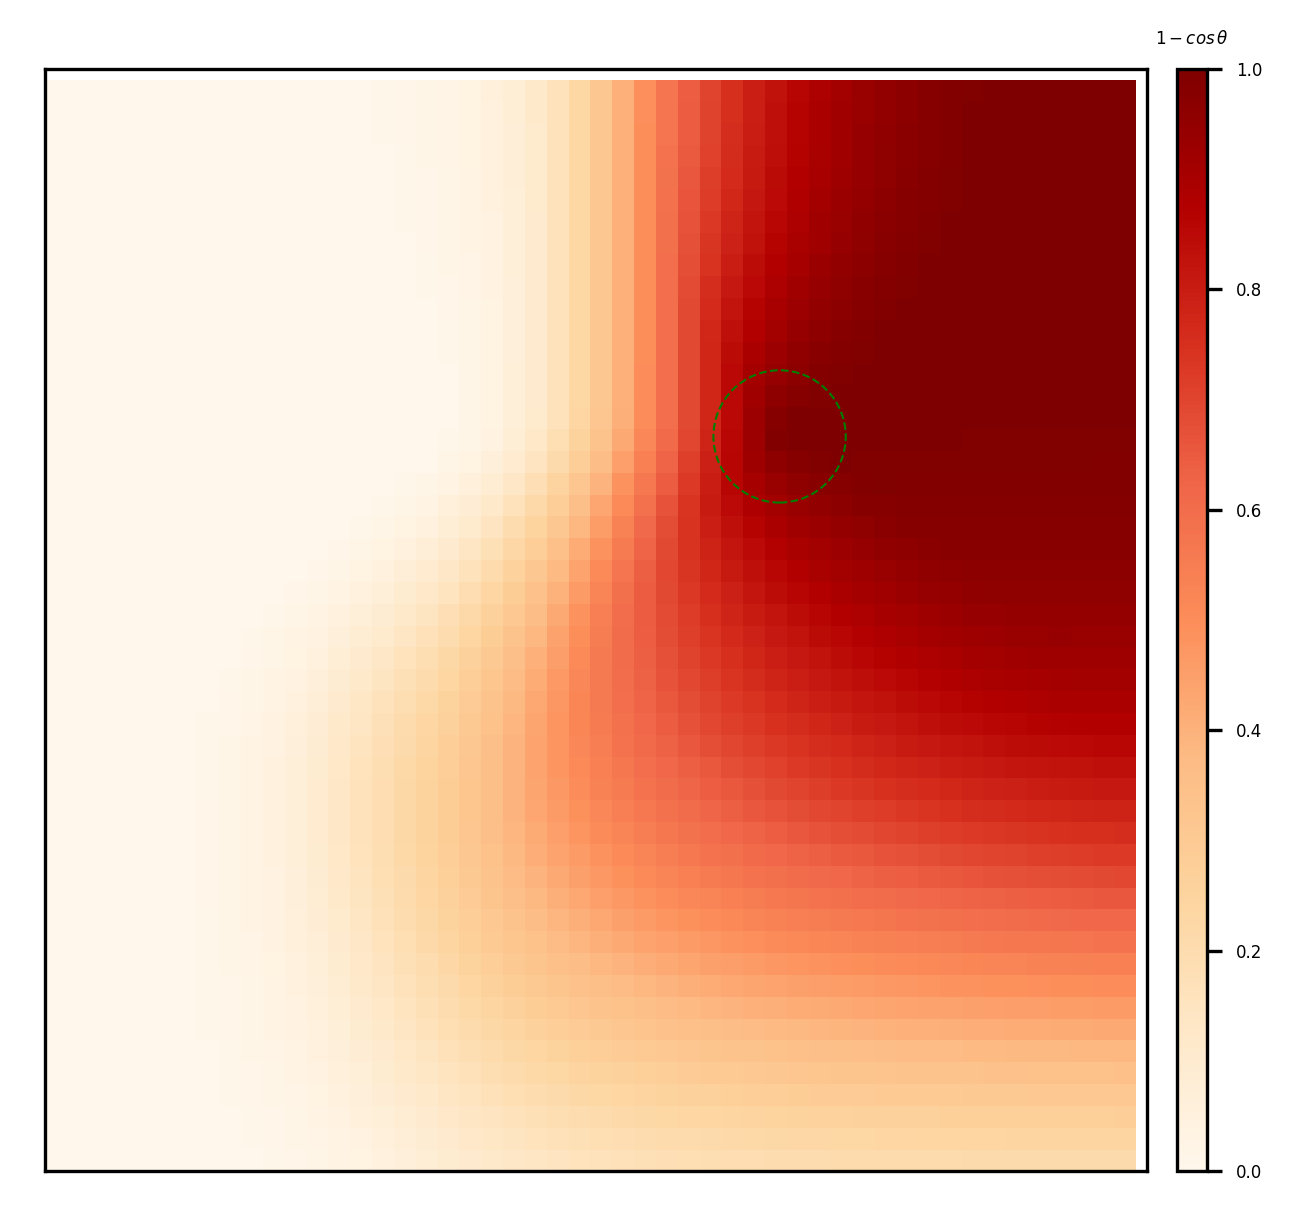

In [43]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
ts, _ = computeTurn(tensor_60, contribution_60_max_sample)
drawTurn(ts, ax=ax, cmap=cm.get_cmap('OrRd'))
c = Circle(pt, radius=0.03,
           linestyle='--', linewidth=0.5, fill=False, color='g')
ax.add_artist(c)
ax.set_xlim([0.5, 1.0])
ax.set_ylim([0.5, 1.0])

plt.savefig('diagrams/degraded59-turn.png')
_ = plt.show()